<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_2a_acquire_OLCI_time_series.ipynb" target="_blank"><< OLCI data access: Acquiring a regional times series</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./2_3a_OLCI_SNAP_batch_processing_subset_reproj_flag_CHL.ipynb" target="_blank">OLCI SNAP processing: subsetting, reprojection and flagging >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT)

<html>
    <div style="float:left"><a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-olci"><img src="https://img.shields.io/badge/open-EUMETLAB-E67E22.svg?style=flat&logo=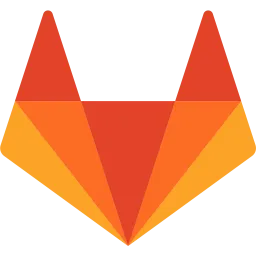" alt="Open in EUMETLAB"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
  <div style="width:100%">
    <div style="float:left"><a href="https://user.eumetsat.int/search-view?term=learn%20olci&sort=score%20desc&facets=%7B%22contentTypes%22:%5B%22Resources%7CSoftware%20%26%20code%22%5D,%22org-satellite-sensor%22:%5B%22EUMETSAT%7CSentinel-3%7COLCI%22%5D,%22theme%22:%5B%22Marine%22,%22Marine%7CMaritime%20safety%22,%22Marine%7COcean%20biogeochemistry%22,%22Marine%7COcean%20dynamics%22,%22Marine%7CWater%20quality%22%5D%7D"><img src="https://img.shields.io/badge/open-USER PORTAL-154360.svg?style=flat&logo=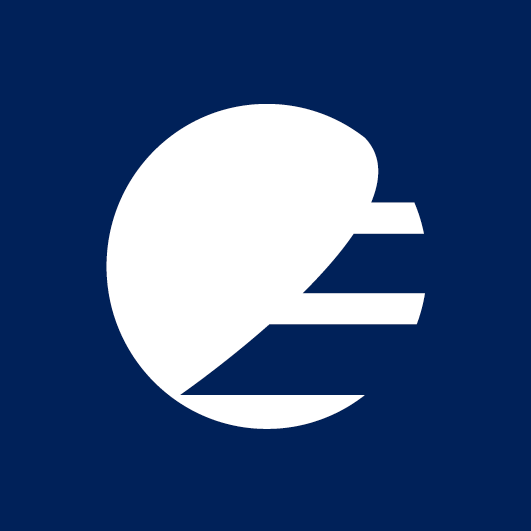" alt="Open in user portal"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-olci/HEAD?urlpath=%2Ftree%2F2_OLCI_advanced%2F2_2b_OLCI_ope_rep_time_series.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Launch on Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
  <div style="width:100%">
    <div style="float:left"><a href="https://jupyterhub.prod.wekeo2.eu/hub/user-redirect/lab/tree/public/wekeo4oceans/learn-olci/2_OLCI_advanced/2_2b_OLCI_ope_rep_time_series.ipynb"><img src="https://img.shields.io/badge/launch-WEKEO-1a4696.svg?style=flat&logo=" alt="Launch on WEkEO"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div> 
</html>

<div class="alert alert-block alert-success">
<h3>Learn OLCI: Advanced</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
Users should review the following notebooks for more information on setting up a credentials files for using the eumdac python library to retrieve OLCI data from the Data Store:
    
- **<a href="../1_OLCI_introductory/1_1a_OLCI_data_access_Data_Store.ipynb">1_1a_OLCI_data_access_Data_Store.ipynb</a>**

</div>
<hr>

# 2.2b Acquiring OLCI timeseries from operational and reprocessed collections

### Data used

| Dataset | EUMETSAT Data Store<br>collection ID| EUMETSAT collection<br>description | WEkEO dataset ID | WEkEO description |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 OLCI level 1b full resolution | EO:EUM:DAT:0409 | <a href="https://user.eumetsat.int/catalogue/EO:EUM:DAT:SENTINEL-3:OL_1_EFR___NTC" target="_blank">Description</a> | EO:EUM:DAT:SENTINEL-3:OL_1_EFR___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3AOL_1_EFR___" target="_blank">Description</a> |
| Sentinel-3 OLCI level 2 full resolution BC003 reprocessing | EO:EUM:DAT:0556 | <a href="https://user.eumetsat.int/catalogue/EO:EUM:DAT:0556" target="_blank">Description</a> | EO:EUM:DAT:SENTINEL-3:0556 | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3A0556" target="_blank">Description</a> |

### Learning outcomes

At the end of this notebook you will know;
* <font color="#138D75">**Search**</font> for a time series of operational and reprocessed L2 OLCI data for your region of interest using the EUMETSAT Data Store API client (`eumdac`)
* Truncate your operational time series according to available reprocessed data
* <font color="#138D75">**Download**</font> this time series

### Outline

The EUMETSAT Data Store offers many ways to interact with data in order to refine searches. Many of these methods are supported by the EUMETSAT Data Access Client (`eumdac`). In this notebook we will showcase some of the possibilities for using `eumdac` to better interact with OLCI collections. This notebook assumes that you already have an understanding of the available Data Store interfaces, which you can gain by running the **<a href="../1_OLCI_introductory/1_1a_OLCI_data_access_Data_Store.ipynb">1_1a_OLCI_data_access_Data_Store</a>** notebook.


<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
1. [Step 1: Authenticating the API](#section1)
1. [Step 2: Creating a search by collection](#section2)
1. [Step 3: Filtering by space](#section3)
1. [Step 4: Filtering the operational collection by timeliness](#section4)
1. [Step 5: Filtering the operational collection by time](#section5) 
1. [Step 6: Removing operational NTC duplicates](#section6)
1. [Step 7: Downloading the full sequence](#section7)

<hr>

In [1]:
import datetime              # a libary that allows us to work with dates and times
import os                    # a library that allows us access to basic operating system commands like making directories
from pathlib import Path     # a library that helps construct system path objects
from shapely import geometry # a library that support construction of geometry objects
import shutil                # a library that allows us access to basic operating system commands like copy
import zipfile               # a library that allows us to unzip zip-files.
import eumdac                # a tool that helps us download via the eumetsat/data-store

# Create a download directory for our SLSTR products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>Step 1: Authenticating the API
[Back to top](#TOC-TOP)

</div>

Before we use the Data Store to download data, we must first authenticate our access and retrieve an access token. More **essential** information on setting this up can be found in the **<a href="../1_OLCI_introductory/1_1a_OLCI_data_access_Data_Store.ipynb">1_1a_OLCI_data_access_Data_Store</a>** notebook.

In [2]:
# load credentials
credentials_file = os.path.join(os.path.expanduser("~"),'.eumdac','credentials')
credentials = Path(credentials_file).read_text().split(',')
token = eumdac.AccessToken((credentials[0], credentials[1]))
print(f"This token '{token}' expires {token.expiration}")

# create data store object
datastore = eumdac.DataStore(token)

This token '7d25a5ff-e16c-341e-8439-7e8eeaf76d27' expires 2024-07-18 14:27:16.660612


<div class="alert alert-info" role="alert">

## <a id='section2'></a>Step 2: Creating a search by collection
[Back to top](#TOC-TOP)

</div>

We will work with the OLCI Level-2 full resolution data throughout this notebook. The collection IDs for this data type is `EO:EUM:DAT:0407` for operational products and `EO:EUM:DAT:0556` for baseline collection BC003 reprocessed products. You can find this information on the Data Store (https://data.eumetsat.int/), or ask the `eumdac` client to tell you all the avaiable collections by calling the `eumdac.DataStore(token).collections` method.

In [3]:
# set collection ID for OLCI L2 WFR Operational
collectionID_OPE = 'EO:EUM:DAT:0407'

# set collection ID for OLCI L2 WFR reprocessing BC003
collectionID_REP = 'EO:EUM:DAT:0556'

To filter by collection, we simply provide the collectionID to the `datastore.get_collection method` for our operational and reprocessing selections.

In [4]:
# Use collection ID
selected_collection_OPE = datastore.get_collection(collectionID_OPE)
print(f"{selected_collection_OPE.title}\n---\n{selected_collection_OPE.abstract}")

print("\n")

selected_collection_REP = datastore.get_collection(collectionID_REP)
print(f"{selected_collection_REP.title}\n---\n{selected_collection_REP.abstract}")

OLCI Level 2 Ocean Colour Full Resolution - Sentinel-3
---
OLCI (Ocean and Land Colour Instrument) Ocean Colour Geophysical Products. Full Resolution: 300m at nadir. All Sentinel-3 NRT products are available at pick-up point in less than 3h. Level 2 marine products include the following: * water-leaving reflectances in 16 bands, Oa**_reflectance (Baseline Atmospheric Correction (BAC) algorithm, bands: 400, 412, 442, 490, 510, 560, 620, 665, 674, 681, 709, 754, 779, 865, 885, 1024 nanometer (nm)); *algal pigment concentration in clear waters, chl_oc4me (BAC and maximum band ratio algorithm, log10 scaled); *algal pigment concentration in turbid waters, chl_nn (neural net algorithm, log10 scaled); *total suspended matter concentration, tsm_nn (neural net algorithm, log10 scaled); *diffuse attenuation coefficient Kd of downward irradiance at 490 nm, trsp (BAC and M07 algorithm, log10 scaled); *absorption coefficient at 443 nm of coloured detrital and dissolved organic matter, iop_nn (neura

*Note: can can see a full range of the search options available in a collection object by using the `selected_collection.search_options` method*

<div class="alert alert-info" role="alert">

## <a id='section4'></a>Step 3: Filtering by space
[Back to top](#TOC-TOP)

</div>

We can also add geographical filtering by passing in a <a href="https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry" target="_blank">Well Known Text</a> (WKT) format region of interest into the **geo** argument of the `.search()` method. The box below defines our WKT using the `shapely` geometry library, which is useful as it gives us a polygon object that we later use to compare our ROI area with the granules we are looking at.

In [5]:
# space/time filter the collection for products.
# In this case a 1x1 degree box around the Acqua Alta Oceanographic Tower (AAOT).
north = 45.00
south = 46.00
east = 12.00
west = 13.00
ROI = [[west, south], [east, south], [east, north], [west, north], [west, south]]
ROI_WKT = geometry.Polygon([[p[0], p[1]] for p in ROI])

Now lets use this polygon to refine our search...

In [6]:
products_REP = selected_collection_REP.search(
    geo=ROI_WKT)
print(f"Found {len(products_REP)} reprocessed products")

products_OPE = selected_collection_OPE.search(
    geo=ROI_WKT)
print(f"Found {len(products_OPE)} operational products")

Found 2159 reprocessed products
Found 1792 operational products


<div class="alert alert-info" role="alert">

## <a id='section4'></a>Step 4: Filtering the operational collection by timeliness
[Back to top](#TOC-TOP)

</div>

If we are combinging operational and reprocessing products, we are often onlt interested in Non Time-Critical (NTC) OLCI products. We can add this filter to our search as follows.

In [7]:
products_OPE = selected_collection_OPE.search(
    geo=ROI_WKT, 
    timeliness='NT')
print(f"Found {len(products_OPE)} operational non-time critical products")

Found 1742 operational non-time critical products


<div class="alert alert-info" role="alert">

## <a id='section5'></a>Step 5: Filtering the operational collection by time
[Back to top](#TOC-TOP)

</div>

If our reprocessing and operational records overlap we only wish to retain the former. Put another way, we only want to include the operational products that were created after the end of the reprocessing was completed. We can do this by filtering the operational collection by date, limiting it to dates after the last available reprocessed products to now.

In [8]:
latest = products_REP.first()
file_tags = str(latest).split('_')
file_tags = [i for i in file_tags if i]
latest_date = file_tags[4]
print(f"The last available reprocessing products is at {latest_date}")

The last available reprocessing products is at 20210428T094703


In [9]:
products_OPE = selected_collection_OPE.search(
    geo=ROI_WKT,
    dtstart=datetime.datetime.strptime(latest_date,"%Y%m%dT%H%M%S")+datetime.timedelta(seconds=1),
    timeliness='NT')
print(f"Found {len(products_OPE)} matching products that occur after the end of the reprocessing")

Found 1742 matching products that occur after the end of the reprocessing


<div class="alert alert-info" role="alert">

## <a id='section6'></a>Step 6: Removing operational NTC duplicates
[Back to top](#TOC-TOP)

</div>

Sometimes, during NTC processing, we have to revisit some granules to process them further. This is typically due to missing ancillary data that we have to wait for. In this case, we first pass and final pass products are both on the system. We only want the latter, final, product, which always has a later time. The box below will filter for the latest options only, taking advantage of the Data Stores default to show most recent products first.

In [10]:
processed_list = []
final_products_OPE = []
for product_OPE in products_OPE:
    file_tags = str(product_OPE).split('_')
    file_tags = [i for i in file_tags if i]
    granule_start = file_tags[4]
    if granule_start not in processed_list:
        final_products_OPE.append(product_OPE)
        processed_list.append(granule_start)
        
print(f"Found {len(final_products_OPE)} products")

Found 1739 products


<div class="alert alert-info" role="alert">

## <a id='section7'></a>Step 7: Downloading the full sequence
[Back to top](#TOC-TOP)

</div>

We now have two, mutually exclusive lists of products. We can concatenate them into a single list as follows.

In [11]:
# first we convert our REP search results to a product list so that we can concatenate the two records
final_products_REP = [item for item in products_REP]

# then we concatenate the lists
final_products = final_products_OPE + final_products_REP

If we want to run a quick check on the last available reprocessed product, and first available operational product to ensure that we have no large gaps, we can easily do so.

In [12]:
print(f"The last available reprocessed product is:\n{str(final_products_REP[0])}")
print("\n")
print(f"The first available operational product is:\n{str(final_products_OPE[-1])}")

The last available reprocessed product is:
S3A_OL_2_WFR____20210428T094703_20210428T095003_20220308T095437_0179_071_136______MAR_R_NT_003.SEN3


The first available operational product is:
S3A_OL_2_WFR____20210429T092052_20210429T092352_20210430T193628_0179_071_150_2160_MAR_O_NT_003.SEN3


If we are happy with our time series, then we can go ahead and download it.

In [13]:
max_products = 3
for final_product, count in zip(final_products, range(len(final_products))):
    if count >= max_products:
        continue
    print(f"Download {count}: {final_product}")
    with final_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
        print(f'Downloading {fsrc.name}.')
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {fsrc.name} finished.')

    with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith(str(final_product)):
                zip_ref.extract(file, download_dir)
        print(f'Unzipping of product {fdst.name} finished.')

    os.remove(fdst.name)

Download 0: S3A_OL_2_WFR____20240715T090937_20240715T091237_20240716T160307_0179_114_321_2160_MAR_O_NT_003.SEN3
Download of product S3A_OL_2_WFR____20240715T090937_20240715T091237_20240716T160307_0179_114_321_2160_MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/products/S3A_OL_2_WFR____20240715T090937_20240715T091237_20240716T160307_0179_114_321_2160_MAR_O_NT_003.SEN3.zip finished.
Download 1: S3A_OL_2_WFR____20240714T093547_20240714T093847_20240715T164454_0179_114_307_2160_MAR_O_NT_003.SEN3
Download of product S3A_OL_2_WFR____20240714T093547_20240714T093847_20240715T164454_0179_114_307_2160_MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/products/S3A_OL_2_WFR____20240714T093547_20240714T093847_20240715T164454_0179_114_307_2160_MAR_O_NT_003.SEN3.zip finished.
Download 2: S3B_OL_2_WFR____20240714T085700_20240714T09000

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_2a_acquire_OLCI_time_series.ipynb" target="_blank"><< OLCI data access: Acquiring a regional times series</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./2_3a_OLCI_SNAP_batch_processing_subset_reproj_flag_CHL.ipynb" target="_blank">OLCI SNAP processing: subsetting, reprojection and flagging >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>